벤치마크 모델로 cv 로 튜닝하기 전에 하나 돌리고 얘랑 비교하고 그러자.
MAE 처럼 모델 간 비교할 지표 만들기. r2 든지

### Import and process Dataset

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

from keras.wrappers.scikit_learn import KerasRegressor
#from scikeras.wrappers import KerasRegressor

from sklearn.model_selection import GridSearchCV
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
os.getcwd()
os.chdir('C:\\Users\\hayou\\Desktop\\Hayeon\\Columbia\\2022 Fall\\ML\\Final project')

In [3]:
df = pd.read_csv(r'C:\\Users\\hayou\\Desktop\\Hayeon\\Columbia\\2022 Fall\\ML\\Final project\\ML_Brazil.csv')
df.head()

,year,code,df_,fr_,uf,estado,municipio,popcode,pop,capital,...,milho,soja,area,west,dfper,actualFPM,bovino,CFEM,mining,sand
0,2004,1100015,73.410683,3178.279277,11,Rondônia,Alta Floresta D'Oeste,1.0,29001,0,...,7725.0,100.0,7066.702,1,0.010388,3806682.42,356520.0,1715,24892.0,0.0
1,2004,1100031,20.045996,333.670267,11,Rondônia,Cabixi,3.0,7421,0,...,2200.0,1500.0,1314.355,1,0.015252,1659323.25,126470.0,0,0.0,0.0
2,2004,1100056,16.522153,732.942001,11,Rondônia,Cerejeiras,5.0,17217,0,...,2500.0,7184.0,2783.305,1,0.005936,3318646.22,95498.0,0,0.0,0.0
3,2004,1100064,8.973859,223.336046,11,Rondônia,Colorado do Oeste,6.0,18349,0,...,4000.0,1400.0,1451.058,1,0.006184,3709075.22,226997.0,0,0.0,0.0
4,2004,1100072,8.171861,810.900208,11,Rondônia,Corumbiara,7.0,9411,0,...,3500.0,6000.0,3060.318,1,0.002670,1659323.25,281191.0,0,0.0,0.0


In [4]:
#Assign X and y
list(df.columns)

#create forest ratio
df['frper']=df['fr_']/df['area']
df=df.dropna(subset=['frper','pop','PIB_pc','actualFPM','road','crop','bovino', 'CFEM'])
y=pd.DataFrame(df, columns=['frper'])
X=pd.DataFrame(df, columns=['year','code','pop','PIB_pc','actualFPM','road','crop','bovino', 'CFEM'])
X

,year,code,pop,PIB_pc,actualFPM,road,crop,bovino,CFEM
0,2004,1100015,29001,6034.159857,3806682.42,15465.80,27355,356520.0,1715
1,2004,1100031,7421,8203.643444,1659323.25,38667.00,9240,126470.0,0
2,2004,1100056,17217,8285.490039,3318646.22,253430.07,13831,95498.0,0
4,2004,1100072,9411,9963.625970,1659323.25,345546.98,12647,281191.0,0
5,2004,1100080,11731,4738.743244,2342573.99,77388.82,2795,79145.0,0
...,...,...,...,...,...,...,...,...,...
3918,2012,5108055,10929,13951.304510,6426748.71,2538859.55,5650,265438.0,31473
3919,2012,5108501,10414,34741.481280,6426748.71,0.00,206490,29094.0,0
3920,2012,5108600,22258,13004.427710,9699357.95,2824164.83,28400,709879.0,376
3921,2012,5108907,6989,39060.547150,4607710.53,137024.00,166870,82379.0,0


### Split data

In [5]:
from sklearn.model_selection import train_test_split
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [6]:
print("Training set: {} {}".format(X_train_df.shape, y_train_df.shape))  
print("Testing set:  {} {}".format(X_test_df.shape, y_test_df.shape)) 

Training set: (2771, 9) (2771, 1)
Testing set:  (693, 9) (693, 1)


### Shuffle training data

In [7]:
# Shuffle the training set
X_train_df = shuffle(X_train_df, random_state=1)
y_train_df = shuffle(y_train_df, random_state=1)

#order = np.argsort(np.random.random(y_train.shape))
#X_train = X_train[order]
#y_train = y_train[order]

### Data standardization / normalization

In [8]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)
X_train_df.head()

(2771, 9) (2771, 1) (693, 9)


,year,code,pop,PIB_pc,actualFPM,road,crop,bovino,CFEM
3847,1.442287,2.176297,-0.838165,2.571414,-0.016252,-0.161071,1.384704,-0.267500,-0.057613
2788,0.675925,-0.081590,-0.503756,-0.449624,0.167961,0.850557,-0.271463,-0.691223,-0.058313
3800,1.442287,-0.079929,0.250589,0.965853,1.052203,1.516295,-0.277820,-0.107358,-0.045864
2853,0.675925,2.176140,0.119476,0.738529,0.388669,-0.285240,0.702604,2.656364,-0.026209
1228,-0.856799,-0.372726,-0.784592,-0.574192,-1.060060,-0.363312,-0.295183,-0.508677,-0.058695


# 1. Neural Network Model

## 1.1. Benchmark Model

In [9]:
# set hyperparameters
#n_neuron       = 64 
activation     = 'relu'
num_epochs     = 200
learning_rate  = 0.0001 
minibatch_size = 64
model_num      = 1

In [10]:
#parameter tuning 전 모델인데, 위에 cv에서 나온 파라미터들을 넣기
model_bk = Sequential()

model_bk.add(Dense(64,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model_bk.add(Dense(64,  activation=activation)) #Gridsearch CV에서 값 어떻게 반영하지?
model_bk.add(Dense(32,  activation=activation)) 
model_bk.add(Dense(y_train.shape[1],  activation='linear')) # the output layer

model_bk.summary()

model_bk.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,913
Trainable params: 6,913
Non-trainable params: 0
_________________________________________________________________


### Fit the train data

In [11]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model_bk.fit(X_train, y_train, #위에서 fit 을 define 했었음
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, #train loss
                    verbose         = 0,
                    callbacks       = [early_stop])

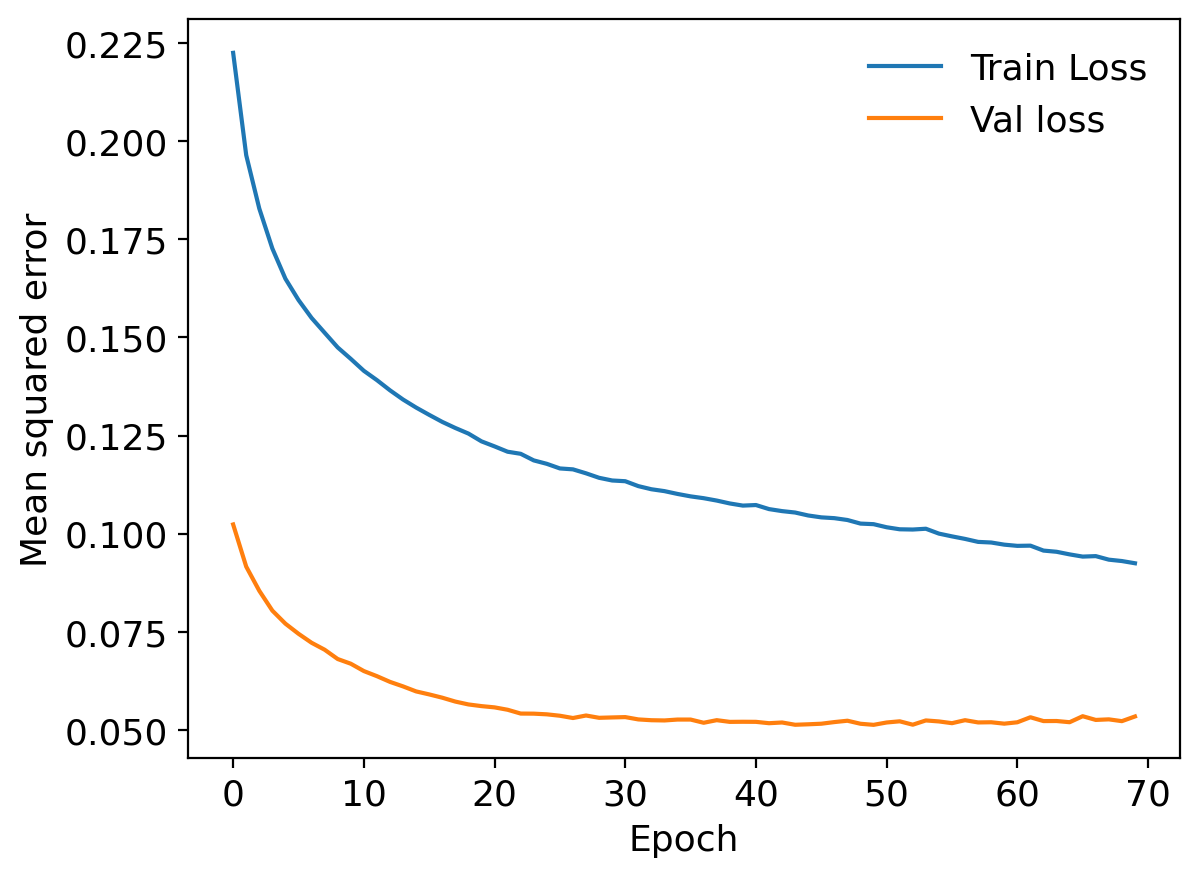

In [12]:
plot_history(history)

### Evaluate the model

In [13]:
print('Available Metrics in Model: {}'.format(model_bk.metrics_names))
[loss, mae] = model_bk.evaluate(X_test, y_test, verbose=0)
print(mae)
print("Testing set Mean Abs Error: {:7.2f}".format(mae))

Available Metrics in Model: ['loss', 'accuracy']
0.09379509091377258
Testing set Mean Abs Error:    0.09


### Predict

22/22 [==============================] - 0s 1ms/step


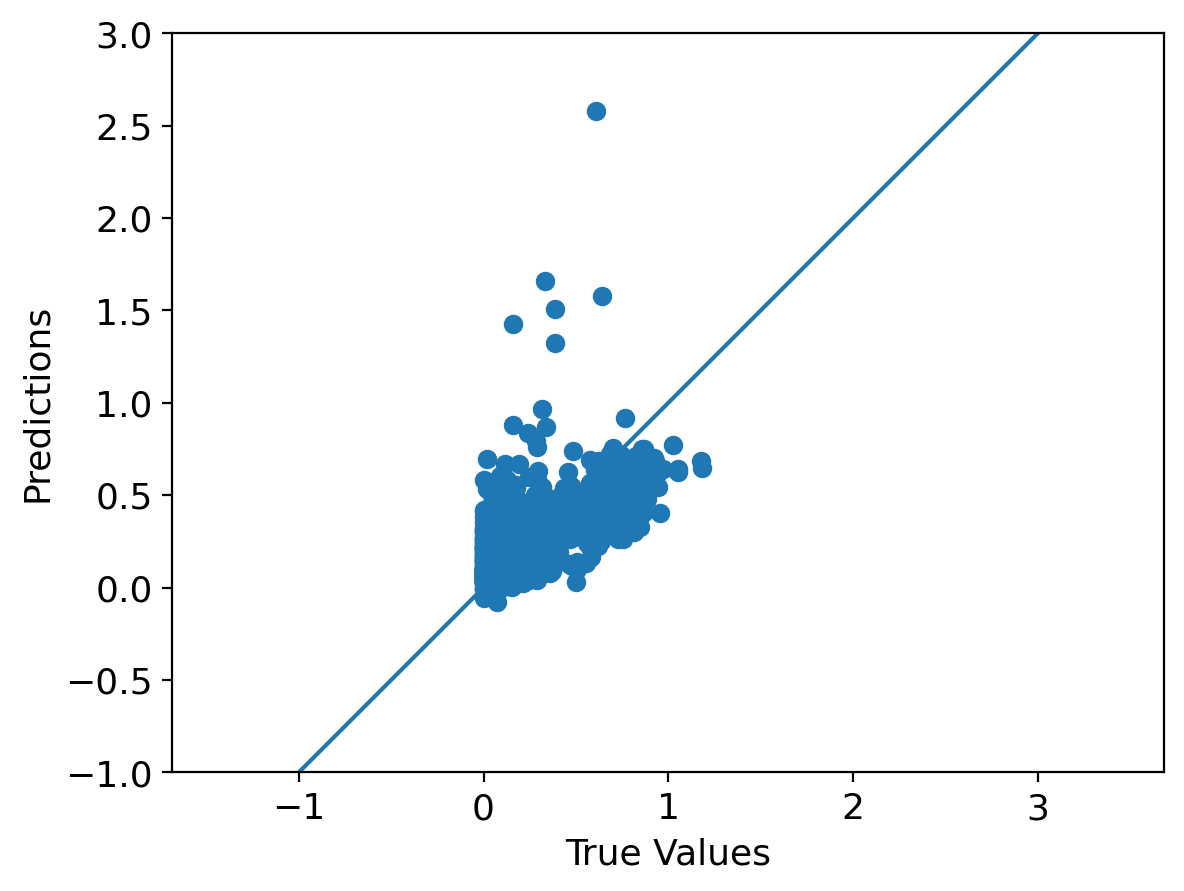

In [14]:
#keras_boston housing price에서 옴
#test_predictions = model.predict(test_data).flatten()  #flatten 왜하지
y_test_pred = model_bk.predict(X_test)
plt.scatter(y_test, y_test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
#plt.xlim(plt.xlim())
#plt.ylim(plt.ylim())
plt.xlim([-1,3])
plt.ylim([-1,3])
_ = plt.plot([-100, 100], [-100, 100])


print(y_test[y_test<3].shape)
print(y_test_pred[y_test_pred<1.7].shape)
print(max(y_test))
print(max(y_test_pred))

나중에 markdown 해제해서 코드로 돌리기. 자꾸 여기서 막혀서 일단 주석해둠.
# Rule out the outlier
plt.scatter(y_test[y_test<2], y_test_pred[y_test_pred<2.5])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

### Calculate MSE and R-squared

In [15]:
mse = mean_squared_error(y_test, y_test_pred)
print(f'the mse is {mse}')
from sklearn.metrics import r2_score
r2_score(y_test,y_test_pred) 
print("the R-squared is {:.3f}".format(r2_score(y_test,y_test_pred)))

the mse is 0.13173636032137567
the R-squared is 0.385


### Plot residuals to see if it follows normal

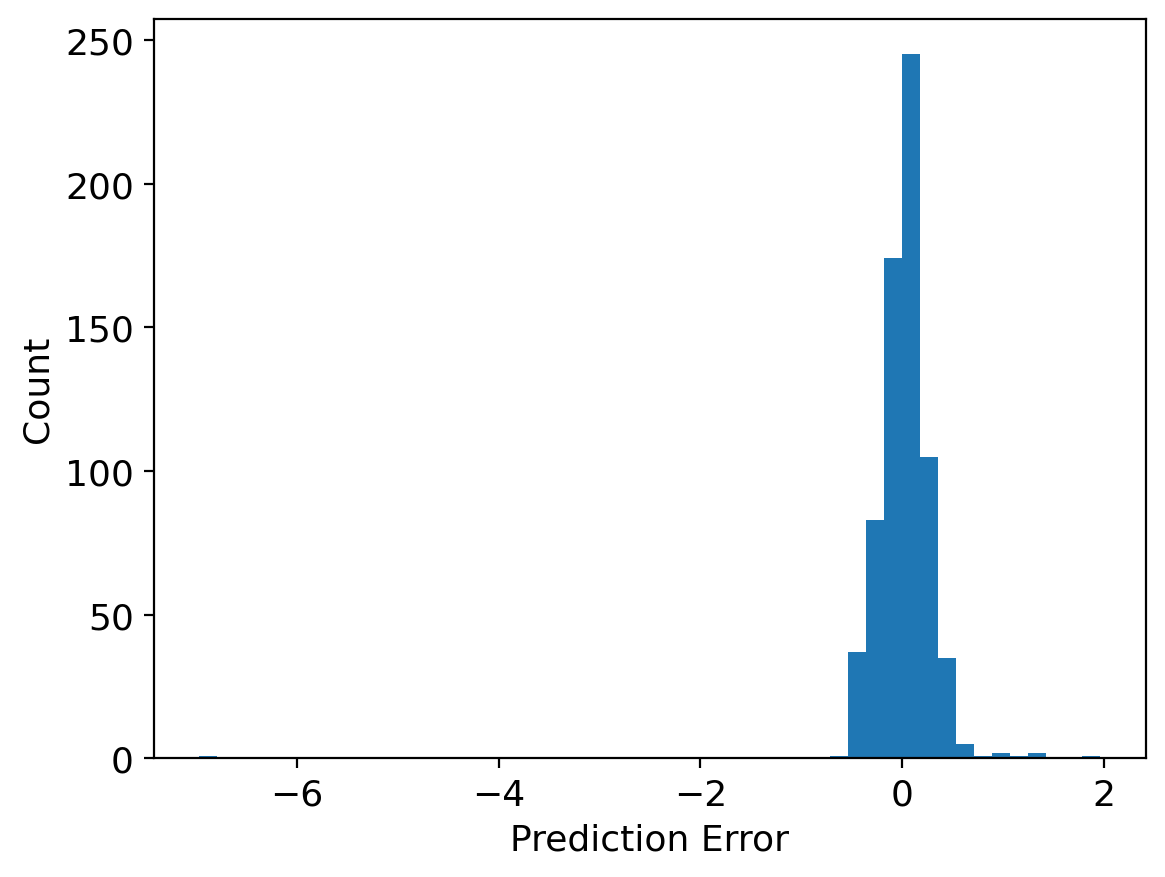

In [16]:
error = y_test_pred - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

## 1.2. A NN Model with hyper parameter tuning
Hyper parameters to be tuned: # of neurons in each layer, epochs.  
For epochs, I have seen from benchmark case that too large epochs may not be optimal, so I tried 10, 20, 50 

#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

순서가 일단 모델 define (Dense 이런 거 하고. ) 
- complie 
- model = KerasClassifier(model=create_model, verbose=0)

#Function to create model, required for KerasClassifier
def create_model(neurons):

 #create model
 model = Sequential()
 model.add(Dense(neurons, input_shape=(8,), kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(4)))
 model.add(Dropout(0.2))
 model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
 
 #Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model
 
#fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

#define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

#optimizer 고르는 부분일아 batch size 등등 고르는 부분이랑 다른데 걍 합쳐서 짜깁기 해둠
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

    
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)


neurons = [1, 5, 10, 15, 20, 25, 30]

#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Note the function create_model() defined above does not return a compiled model like that one in the previous example. This is because setting an optimizer for a Keras model is done in the compile() function call; hence it is better to leave it to the KerasClassifier wrapper and the GridSearchCV model. Also, note that you specified loss="binary_crossentropy" in the wrapper as it should also be set during the compile() function call.

# Use scikit-learn to grid search the number of neurons
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
#from scikeras.wrappers import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.constraints import MaxNorm
# Function to create model, required for KerasClassifier
def create_model(neurons):
    # create model
    model=Sequential()
    model.add(Dense(neurons, input_shape=(8,), kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(4)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
NNmodel = KerasRegressor(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
neurons = [1, 32, 64]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=NNmodel, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Use scikit-learn to grid search the learning rate and momentum
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(8,), activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	return model
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)
# load dataset
dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = KerasClassifier(model=create_model, loss="binary_crossentropy", optimizer="SGD", epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

위에 버리고 그냥 몇 개만 튜닝하자
### Tuning hyperparameters

from sklearn.model_selection import GridSearchCV

param_grid = {'num_epochs': [1, 5, 10, 50, 100, 200],
              'learning_rate': [0.0001, 0.0005, 0.001, 0.005]}


#GridsearchCV from ML for Soc Sci
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=10)

grid.fit(X_train_scaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}\n".format(grid.score(X_test_scaled, y_test)))

#ML for soc sci
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

def make_model(optimizer="adam", hidden_size=32):
model = Sequential([
Dense(hidden_size, input_shape=(784,)),
Activation('relu'),
Dense(10),
Activation('softmax'),
])
model.compile(optimizer=optimizer,loss="categorical_crossentropy",
metrics=['accuracy'])
return model
clf = KerasClassifier(make_model)

param_grid = {'epochs': [1, 5, 10], # epochs is fit parameter, not in make_model!
'hidden_size': [32, 64, 256]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "param_hidden_size"],
values=['mean_train_score', "mean_test_score"])

#ML for soc sci
from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.model_selection import GridSearchCV

def make_model(optimizer="adam", hidden_size=32):
    model = Sequential()
    model.add(Dense(64,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
    model.add(Dense(64,  activation=activation)) #Gridsearch CV에서 값 어떻게 반영하지?
    model.add(Dense(32,  activation=activation)) 
    model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model
clf = KerasRegressor(make_model)

param_grid = {'epochs': [1, 5, 10], # epochs is fit parameter, not in make_model!
'hidden_size': [32, 64, 256]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)


#12/13아래는 돌아가는 버전. 건드리지 말기. learning_rate 는 cv 포함하려다 에러나서 웨이웨이 문의상태

In [17]:
#여기 경우에 적용
#https://www.adriangb.com/scikeras/stable/migration.html
#https://www.nbshare.io/notebook/584445049/Rectified-Linear-Unit-For-Artificial-Neural-Networks-Part-1-Regression/
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
# https://www.geeksforgeeks.org/weight-initialization-techniques-for-deep-neural-networks/

#튜닝할 것들: (epoch), learning rate, layer 개수, (optimizer=adam으로 픽스하기), (activation=reLU 쓰는 듯 regression은)
def make_model(optimizer="adam", hidden_size1=32, hidden_size2=32, hidden_size3=32):
    model = Sequential()
    model.add(Dense(hidden_size1,  activation=activation,input_shape=(X_train.shape[1],))) #기존 64를 hidden size로 대체
    model.add(Dense(hidden_size2,  activation=activation)) 
    model.add(Dense(hidden_size3,  activation=activation)) 
    model.add(Dense(y_train.shape[1],  activation='linear'))

    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

clf = KerasRegressor(make_model,verbose=1)
param_grid = {'epochs': [10, 50, 200], # epochs is fit parameter, not in make_model! 첨에 100 200 했는데 시간 오래걸리고 200이 그리 좋진 않음.
'hidden_size1': [32, 64],
'hidden_size2': [32, 64],
'hidden_size3': [32, 64]}

C:\Users\hayou\AppData\Local\Temp\ipykernel_2304\2449326161.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasRegressor(make_model,verbose=1)


def make_model():
    model = Sequential()
    model.add(Dense(32,  activation=activation,input_shape=(X_train.shape[1],))) 
    model.add(Dense(32,  activation=activation)) 
    model.add(Dense(32,  activation=activation)) 
    model.add(Dense(y_train.shape[1],  activation='linear'))

    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learn_rate), metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

model=make_model()
model.compile()
clf= KerasRegressor(model)
#clf = KerasRegressor(model=make_model, loss="mse", optimizer="Adam", epochs=100, batch_size=10, verbose=0)
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learn_rate)

GridsearchCV 계속 다른 결과 주는 이유: 
https://stackoverflow.com/questions/74805273/source-of-randomness-of-gridsearchcv/74807800#74807800
    Like the commentor said, you are running GridSearch on a neural network with different weights every time, because they are randomly initiliazed. The solution to this would be to fill in initialization weights yourself.
   
내가 츄라이해본 거 - 근데도 mae랑 loss 값은 계속 달라지는 거 같은데, weight initialization을 모든 레이어에 해줘야하는건가?
#Weight initialization
#He Uniform Initialization, too, is suitable for layers where ReLU activation function is used. 

from tensorflow.keras import layers
from tensorflow.keras import initializers
initializer = tf.keras.initializers.HeNormal(seed=1)

#initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
#layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

seed = 7
tf.random.set_seed(seed)

model = Sequential()

model.add(Dense(64,  activation=activation,input_shape=(X_train.shape[1],), kernel_initializer=initializer)) 
model.add(Dense(32,  activation=activation)) 
model.add(Dense(32,  activation=activation)) 
model.add(Dense(y_train.shape[1],  activation='linear')) 

model.summary()

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

In [ ]:
%time
grid = GridSearchCV(clf, param_grid=param_grid, cv=3, return_train_score=True)
grid.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/10
58/58 [==============================] - 1s 2ms/step - loss: 0.2023 - accuracy: 0.1007
Epoch 2/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.0991
Epoch 3/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1077 - accuracy: 0.0985
Epoch 4/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.1007
Epoch 5/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0921 - accuracy: 0.1007
Epoch 6/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0875 - accuracy: 0.1007
Epoch 7/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0839 - accuracy: 0.1007
Epoch 8/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0808 - accuracy: 0.1007
Epoch 9/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0781 - accuracy: 0.1007
Epoch 10/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0743

58/58 [==============================] - 1s 2ms/step - loss: 0.2292 - accuracy: 0.0942
Epoch 2/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1964 - accuracy: 0.0915
Epoch 3/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1851 - accuracy: 0.0931
Epoch 4/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1784 - accuracy: 0.0920
Epoch 5/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1742 - accuracy: 0.0942
Epoch 6/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1707 - accuracy: 0.0931
Epoch 7/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1673 - accuracy: 0.0937
Epoch 8/10
58/58 [==============================] - 0s 3ms/step - loss: 0.1649 - accuracy: 0.0937
Epoch 9/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1622 - accuracy: 0.0942
Epoch 10/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1573 - accuracy: 0.0942
Epoch 1/10
58/58 [============

58/58 [==============================] - 0s 1ms/step - loss: 0.1969 - accuracy: 0.0904
Epoch 3/10
58/58 [==============================] - 0s 1ms/step - loss: 0.1865 - accuracy: 0.0904
Epoch 4/10
58/58 [==============================] - 0s 1ms/step - loss: 0.1795 - accuracy: 0.0915
Epoch 5/10
58/58 [==============================] - 0s 1ms/step - loss: 0.1740 - accuracy: 0.0925
Epoch 6/10
58/58 [==============================] - 0s 1ms/step - loss: 0.1694 - accuracy: 0.0925
Epoch 7/10
58/58 [==============================] - 0s 1ms/step - loss: 0.1652 - accuracy: 0.0936
Epoch 8/10
58/58 [==============================] - 0s 1ms/step - loss: 0.1612 - accuracy: 0.0936
Epoch 9/10
58/58 [==============================] - 0s 1ms/step - loss: 0.1579 - accuracy: 0.0942
Epoch 10/10
58/58 [==============================] - 0s 1ms/step - loss: 0.1530 - accuracy: 0.0942
Epoch 1/10
58/58 [==============================] - 1s 1ms/step - loss: 0.1816 - accuracy: 0.1007
Epoch 2/10
58/58 [============

58/58 [==============================] - 0s 2ms/step - loss: 0.0876 - accuracy: 0.1007
Epoch 4/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0801 - accuracy: 0.1007
Epoch 5/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0743 - accuracy: 0.1007
Epoch 6/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.1007
Epoch 7/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0658 - accuracy: 0.1007
Epoch 8/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.1007
Epoch 9/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0593 - accuracy: 0.1007
Epoch 10/10
58/58 [==============================] - 0s 1ms/step - loss: 0.0549 - accuracy: 0.1007
Epoch 1/10
58/58 [==============================] - 1s 3ms/step - loss: 0.2028 - accuracy: 0.0942
Epoch 2/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1870 - accuracy: 0.0942
Epoch 3/10
58/58 [============

58/58 [==============================] - 0s 1ms/step - loss: 0.0475 - accuracy: 0.1007
Epoch 1/50
58/58 [==============================] - 1s 1ms/step - loss: 0.2795 - accuracy: 0.0942
Epoch 2/50
58/58 [==============================] - 0s 1ms/step - loss: 0.2301 - accuracy: 0.0931
Epoch 3/50
58/58 [==============================] - 0s 2ms/step - loss: 0.2009 - accuracy: 0.0931
Epoch 4/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.0926
Epoch 5/50
58/58 [==============================] - 0s 1ms/step - loss: 0.1793 - accuracy: 0.0931
Epoch 6/50
58/58 [==============================] - 0s 1ms/step - loss: 0.1751 - accuracy: 0.0931
Epoch 7/50
58/58 [==============================] - 0s 1ms/step - loss: 0.1720 - accuracy: 0.0931
Epoch 8/50
58/58 [==============================] - 0s 1ms/step - loss: 0.1698 - accuracy: 0.0931
Epoch 9/50
58/58 [==============================] - 0s 1ms/step - loss: 0.1675 - accuracy: 0.0937
Epoch 10/50
58/58 [============

58/58 [==============================] - 0s 2ms/step - loss: 0.1414 - accuracy: 0.0936
Epoch 30/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.0936
Epoch 31/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1388 - accuracy: 0.0936
Epoch 32/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1373 - accuracy: 0.0936
Epoch 33/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1360 - accuracy: 0.0936
Epoch 34/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1348 - accuracy: 0.0936
Epoch 35/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1337 - accuracy: 0.0936
Epoch 36/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1322 - accuracy: 0.0936
Epoch 37/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1309 - accuracy: 0.0936
Epoch 38/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1298 - accuracy: 0.0936
Epoch 39/50
58/58 [===

58/58 [==============================] - 0s 2ms/step - loss: 0.1639 - accuracy: 0.0942
Epoch 9/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1610 - accuracy: 0.0942
Epoch 10/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1583 - accuracy: 0.0942
Epoch 11/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1557 - accuracy: 0.0942
Epoch 12/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1536 - accuracy: 0.0942
Epoch 13/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1510 - accuracy: 0.0942
Epoch 14/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1479 - accuracy: 0.0942
Epoch 15/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1452 - accuracy: 0.0942
Epoch 16/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1430 - accuracy: 0.0942
Epoch 17/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1418 - accuracy: 0.0942
Epoch 18/50
58/58 [====

58/58 [==============================] - 0s 2ms/step - loss: 0.1226 - accuracy: 0.0942
Epoch 40/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.0942
Epoch 41/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1211 - accuracy: 0.0942
Epoch 42/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1206 - accuracy: 0.0942
Epoch 43/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1198 - accuracy: 0.0942
Epoch 44/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1193 - accuracy: 0.0942
Epoch 45/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1186 - accuracy: 0.0942
Epoch 46/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1178 - accuracy: 0.0942
Epoch 47/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1170 - accuracy: 0.0942
Epoch 48/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1164 - accuracy: 0.0942
Epoch 49/50
58/58 [===

58/58 [==============================] - 0s 2ms/step - loss: 0.1415 - accuracy: 0.0942
Epoch 19/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.0942
Epoch 20/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1383 - accuracy: 0.0942
Epoch 21/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1371 - accuracy: 0.0942
Epoch 22/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1356 - accuracy: 0.0942
Epoch 23/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1345 - accuracy: 0.0942
Epoch 24/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1334 - accuracy: 0.0942
Epoch 25/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.0942
Epoch 26/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1313 - accuracy: 0.0942
Epoch 27/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1299 - accuracy: 0.0942
Epoch 28/50
58/58 [===

58/58 [==============================] - 0s 2ms/step - loss: 0.1119 - accuracy: 0.0942
Epoch 50/50
58/58 [==============================] - 0s 1ms/step - loss: 0.1101 - accuracy: 0.0942
Epoch 1/50
58/58 [==============================] - 1s 2ms/step - loss: 0.1381 - accuracy: 0.1007
Epoch 2/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1006 - accuracy: 0.1007
Epoch 3/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0911 - accuracy: 0.1007
Epoch 4/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0866 - accuracy: 0.1007
Epoch 5/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0833 - accuracy: 0.1007
Epoch 6/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0807 - accuracy: 0.1002
Epoch 7/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0785 - accuracy: 0.1007
Epoch 8/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0767 - accuracy: 0.1002
Epoch 9/50
58/58 [============

58/58 [==============================] - 0s 3ms/step - loss: 0.1214 - accuracy: 0.0942
Epoch 29/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1220 - accuracy: 0.0942
Epoch 30/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1199 - accuracy: 0.0942
Epoch 31/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1196 - accuracy: 0.0942
Epoch 32/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1187 - accuracy: 0.0942
Epoch 33/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1182 - accuracy: 0.0942
Epoch 34/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1170 - accuracy: 0.0942
Epoch 35/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1160 - accuracy: 0.0942
Epoch 36/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1162 - accuracy: 0.0942
Epoch 37/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1159 - accuracy: 0.0942
Epoch 38/50
58/58 [===

58/58 [==============================] - 0s 2ms/step - loss: 0.0879 - accuracy: 0.1002
Epoch 8/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0852 - accuracy: 0.1002
Epoch 9/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0828 - accuracy: 0.1002
Epoch 10/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0808 - accuracy: 0.1002
Epoch 11/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0788 - accuracy: 0.1002
Epoch 12/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0769 - accuracy: 0.1002
Epoch 13/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.1002
Epoch 14/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0730 - accuracy: 0.1002
Epoch 15/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0712 - accuracy: 0.1002
Epoch 16/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.1002
Epoch 17/50
58/58 [=====

58/58 [==============================] - 0s 2ms/step - loss: 0.1217 - accuracy: 0.0942
Epoch 39/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1204 - accuracy: 0.0942
Epoch 40/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1199 - accuracy: 0.0942
Epoch 41/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1187 - accuracy: 0.0942
Epoch 42/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1184 - accuracy: 0.0942
Epoch 43/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1176 - accuracy: 0.0942
Epoch 44/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1167 - accuracy: 0.0942
Epoch 45/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1161 - accuracy: 0.0942
Epoch 46/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1156 - accuracy: 0.0942
Epoch 47/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1149 - accuracy: 0.0942
Epoch 48/50
58/58 [===

58/58 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.1007
Epoch 18/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0545 - accuracy: 0.1007
Epoch 19/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.1007
Epoch 20/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0518 - accuracy: 0.1007
Epoch 21/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0508 - accuracy: 0.1007
Epoch 22/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0499 - accuracy: 0.1007
Epoch 23/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0491 - accuracy: 0.1007
Epoch 24/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0481 - accuracy: 0.1007
Epoch 25/50
58/58 [==============================] - 0s 3ms/step - loss: 0.0474 - accuracy: 0.1007
Epoch 26/50
58/58 [==============================] - 0s 3ms/step - loss: 0.0469 - accuracy: 0.1007
Epoch 27/50
58/58 [===

58/58 [==============================] - 0s 3ms/step - loss: 0.1149 - accuracy: 0.0942
Epoch 49/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1149 - accuracy: 0.0942
Epoch 50/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1129 - accuracy: 0.0942
Epoch 1/50
58/58 [==============================] - 1s 2ms/step - loss: 0.2543 - accuracy: 0.0915
Epoch 2/50
58/58 [==============================] - 0s 2ms/step - loss: 0.2197 - accuracy: 0.0909
Epoch 3/50
58/58 [==============================] - 0s 4ms/step - loss: 0.2053 - accuracy: 0.0909
Epoch 4/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1950 - accuracy: 0.0915
Epoch 5/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1874 - accuracy: 0.0909
Epoch 6/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1808 - accuracy: 0.0909
Epoch 7/50
58/58 [==============================] - 0s 3ms/step - loss: 0.1753 - accuracy: 0.0920
Epoch 8/50
58/58 [===========

58/58 [==============================] - 0s 2ms/step - loss: 0.0420 - accuracy: 0.1007
Epoch 28/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0417 - accuracy: 0.1007
Epoch 29/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.1007
Epoch 30/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.1007
Epoch 31/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0409 - accuracy: 0.1007
Epoch 32/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0403 - accuracy: 0.1007
Epoch 33/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0403 - accuracy: 0.1007
Epoch 34/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0400 - accuracy: 0.1007
Epoch 35/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.1007
Epoch 36/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0394 - accuracy: 0.1007
Epoch 37/50
58/58 [===

58/58 [==============================] - 0s 2ms/step - loss: 0.1547 - accuracy: 0.0909
Epoch 7/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1506 - accuracy: 0.0920
Epoch 8/50
58/58 [==============================] - 0s 1ms/step - loss: 0.1465 - accuracy: 0.0915
Epoch 9/50
58/58 [==============================] - 0s 1ms/step - loss: 0.1431 - accuracy: 0.0925
Epoch 10/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1405 - accuracy: 0.0942
Epoch 11/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1380 - accuracy: 0.0942
Epoch 12/50
58/58 [==============================] - 0s 1ms/step - loss: 0.1358 - accuracy: 0.0942
Epoch 13/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.0942
Epoch 14/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1330 - accuracy: 0.0942
Epoch 15/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1313 - accuracy: 0.0942
Epoch 16/50
58/58 [======

58/58 [==============================] - 0s 1ms/step - loss: 0.0389 - accuracy: 0.1007
Epoch 38/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0388 - accuracy: 0.1007
Epoch 39/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0386 - accuracy: 0.1007
Epoch 40/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0382 - accuracy: 0.1007
Epoch 41/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0379 - accuracy: 0.1007
Epoch 42/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0377 - accuracy: 0.1007
Epoch 43/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0376 - accuracy: 0.1007
Epoch 44/50
58/58 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.1007
Epoch 45/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0371 - accuracy: 0.1007
Epoch 46/50
58/58 [==============================] - 0s 1ms/step - loss: 0.0369 - accuracy: 0.1007
Epoch 47/50
58/58 [===

58/58 [==============================] - 0s 3ms/step - loss: 0.1296 - accuracy: 0.0942
Epoch 17/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1284 - accuracy: 0.0942
Epoch 18/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1269 - accuracy: 0.0942
Epoch 19/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1251 - accuracy: 0.0942
Epoch 20/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1238 - accuracy: 0.0942
Epoch 21/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.0942
Epoch 22/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1216 - accuracy: 0.0942
Epoch 23/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1206 - accuracy: 0.0942
Epoch 24/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1191 - accuracy: 0.0942
Epoch 25/50
58/58 [==============================] - 0s 2ms/step - loss: 0.1189 - accuracy: 0.0942
Epoch 26/50
58/58 [===

58/58 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 0.1007
Epoch 47/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0458 - accuracy: 0.1007
Epoch 48/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0455 - accuracy: 0.1007
Epoch 49/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.1007
Epoch 50/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.1007
Epoch 51/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0449 - accuracy: 0.1007
Epoch 52/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0445 - accuracy: 0.1002
Epoch 53/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0444 - accuracy: 0.1007
Epoch 54/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.1007
Epoch 55/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.1007
Epoch 56/200


58/58 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.1007
Epoch 128/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.1007
Epoch 129/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.1007
Epoch 130/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.1007
Epoch 131/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0340 - accuracy: 0.1007
Epoch 132/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0339 - accuracy: 0.1007
Epoch 133/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.1007
Epoch 134/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0337 - accuracy: 0.1007
Epoch 135/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.1007
Epoch 136/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0335 - accuracy: 0.1007
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.0942
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1846 - accuracy: 0.0942
Epoch 8/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1783 - accuracy: 0.0937
Epoch 9/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1733 - accuracy: 0.0937
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1697 - accuracy: 0.0937
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1665 - accuracy: 0.0937
Epoch 12/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1641 - accuracy: 0.0937
Epoch 13/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1617 - accuracy: 0.0937
Epoch 14/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.0937
Epoch 15/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.0937
Epoch 16/200
58/

58/58 [==============================] - 0s 2ms/step - loss: 0.1050 - accuracy: 0.0937
Epoch 89/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1046 - accuracy: 0.0937
Epoch 90/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1041 - accuracy: 0.0937
Epoch 91/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1045 - accuracy: 0.0937
Epoch 92/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1038 - accuracy: 0.0937
Epoch 93/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1031 - accuracy: 0.0937
Epoch 94/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1028 - accuracy: 0.0937
Epoch 95/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1024 - accuracy: 0.0937
Epoch 96/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1022 - accuracy: 0.0942
Epoch 97/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1016 - accuracy: 0.0942
Epoch 98/200


58/58 [==============================] - 0s 2ms/step - loss: 0.0827 - accuracy: 0.0942
Epoch 170/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0823 - accuracy: 0.0942
Epoch 171/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0823 - accuracy: 0.0942
Epoch 172/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.0942
Epoch 173/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0819 - accuracy: 0.0942
Epoch 174/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.0942
Epoch 175/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0810 - accuracy: 0.0942
Epoch 176/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0811 - accuracy: 0.0942
Epoch 177/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0811 - accuracy: 0.0942
Epoch 178/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0807 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 3ms/step - loss: 0.1161 - accuracy: 0.0942
Epoch 50/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1158 - accuracy: 0.0942
Epoch 51/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1153 - accuracy: 0.0942
Epoch 52/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1151 - accuracy: 0.0942
Epoch 53/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1142 - accuracy: 0.0942
Epoch 54/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1139 - accuracy: 0.0942
Epoch 55/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1134 - accuracy: 0.0942
Epoch 56/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1132 - accuracy: 0.0942
Epoch 57/200
58/58 [==============================] - 0s 4ms/step - loss: 0.1125 - accuracy: 0.0942
Epoch 58/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1122 - accuracy: 0.0942
Epoch 59/200


58/58 [==============================] - 0s 4ms/step - loss: 0.0849 - accuracy: 0.0942
Epoch 131/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0845 - accuracy: 0.0942
Epoch 132/200
58/58 [==============================] - 0s 5ms/step - loss: 0.0840 - accuracy: 0.0942
Epoch 133/200
58/58 [==============================] - 0s 5ms/step - loss: 0.0842 - accuracy: 0.0942
Epoch 134/200
58/58 [==============================] - 0s 7ms/step - loss: 0.0836 - accuracy: 0.0942
Epoch 135/200
58/58 [==============================] - 0s 7ms/step - loss: 0.0833 - accuracy: 0.0942
Epoch 136/200
58/58 [==============================] - 0s 7ms/step - loss: 0.0831 - accuracy: 0.0942
Epoch 137/200
58/58 [==============================] - 0s 5ms/step - loss: 0.0829 - accuracy: 0.0942
Epoch 138/200
58/58 [==============================] - 0s 8ms/step - loss: 0.0828 - accuracy: 0.0942
Epoch 139/200
58/58 [==============================] - 0s 6ms/step - loss: 0.0820 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.0750 - accuracy: 0.1002
Epoch 10/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0724 - accuracy: 0.1007
Epoch 11/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.1007
Epoch 12/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0676 - accuracy: 0.1007
Epoch 13/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0653 - accuracy: 0.1007
Epoch 14/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0634 - accuracy: 0.1007
Epoch 15/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0615 - accuracy: 0.1007
Epoch 16/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0599 - accuracy: 0.1007
Epoch 17/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0585 - accuracy: 0.1007
Epoch 18/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0573 - accuracy: 0.1007
Epoch 19/200


58/58 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.1007
Epoch 92/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.1007
Epoch 93/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.1007
Epoch 94/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.1007
Epoch 95/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0335 - accuracy: 0.1007
Epoch 96/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.1007
Epoch 97/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.1007
Epoch 98/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0332 - accuracy: 0.1007
Epoch 99/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0330 - accuracy: 0.1007
Epoch 100/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0331 - accuracy: 0.1007
Epoch 101/20

58/58 [==============================] - 0s 1ms/step - loss: 0.0281 - accuracy: 0.1007
Epoch 173/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0282 - accuracy: 0.1007
Epoch 174/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0280 - accuracy: 0.1007
Epoch 175/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0280 - accuracy: 0.1007
Epoch 176/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0278 - accuracy: 0.1007
Epoch 177/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0279 - accuracy: 0.1007
Epoch 178/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0277 - accuracy: 0.1007
Epoch 179/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0278 - accuracy: 0.1007
Epoch 180/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.1007
Epoch 181/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0276 - accuracy: 0.1007
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.1126 - accuracy: 0.0937
Epoch 53/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1123 - accuracy: 0.0942
Epoch 54/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1115 - accuracy: 0.0937
Epoch 55/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1108 - accuracy: 0.0942
Epoch 56/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1107 - accuracy: 0.0942
Epoch 57/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1101 - accuracy: 0.0942
Epoch 58/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1092 - accuracy: 0.0942
Epoch 59/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1093 - accuracy: 0.0942
Epoch 60/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1089 - accuracy: 0.0942
Epoch 61/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1078 - accuracy: 0.0942
Epoch 62/200


58/58 [==============================] - 0s 1ms/step - loss: 0.0821 - accuracy: 0.0942
Epoch 134/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.0942
Epoch 135/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0816 - accuracy: 0.0942
Epoch 136/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.0942
Epoch 137/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0803 - accuracy: 0.0942
Epoch 138/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0805 - accuracy: 0.0942
Epoch 139/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0805 - accuracy: 0.0942
Epoch 140/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0805 - accuracy: 0.0942
Epoch 141/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0814 - accuracy: 0.0942
Epoch 142/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0805 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.1587 - accuracy: 0.0942
Epoch 13/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1567 - accuracy: 0.0942
Epoch 14/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1554 - accuracy: 0.0942
Epoch 15/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1532 - accuracy: 0.0942
Epoch 16/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1514 - accuracy: 0.0942
Epoch 17/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1499 - accuracy: 0.0942
Epoch 18/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.0942
Epoch 19/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1468 - accuracy: 0.0942
Epoch 20/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.0942
Epoch 21/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1441 - accuracy: 0.0942
Epoch 22/200


58/58 [==============================] - 0s 1ms/step - loss: 0.1005 - accuracy: 0.0942
Epoch 95/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0997 - accuracy: 0.0942
Epoch 96/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0992 - accuracy: 0.0942
Epoch 97/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0989 - accuracy: 0.0942
Epoch 98/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0986 - accuracy: 0.0942
Epoch 99/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0979 - accuracy: 0.0942
Epoch 100/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0977 - accuracy: 0.0942
Epoch 101/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.0942
Epoch 102/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0971 - accuracy: 0.0942
Epoch 103/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0965 - accuracy: 0.0942
Epoch 104

58/58 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.0942
Epoch 176/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0703 - accuracy: 0.0942
Epoch 177/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.0942
Epoch 178/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0942
Epoch 179/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.0942
Epoch 180/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.0942
Epoch 181/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.0942
Epoch 182/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.0942
Epoch 183/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.0942
Epoch 184/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.1007
Epoch 56/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0409 - accuracy: 0.1007
Epoch 57/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 0.1007
Epoch 58/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0403 - accuracy: 0.1007
Epoch 59/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0401 - accuracy: 0.1007
Epoch 60/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 0.1007
Epoch 61/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 0.1007
Epoch 62/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.1007
Epoch 63/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0394 - accuracy: 0.1007
Epoch 64/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0394 - accuracy: 0.1007
Epoch 65/200


58/58 [==============================] - 0s 4ms/step - loss: 0.0296 - accuracy: 0.1007
Epoch 137/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.1007
Epoch 138/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0293 - accuracy: 0.1007
Epoch 139/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.1007
Epoch 140/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.1007
Epoch 141/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.1007
Epoch 142/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.1007
Epoch 143/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.1007
Epoch 144/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.1007
Epoch 145/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.1007
Epoc

58/58 [==============================] - 0s 3ms/step - loss: 0.1510 - accuracy: 0.0942
Epoch 16/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1491 - accuracy: 0.0942
Epoch 17/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1480 - accuracy: 0.0942
Epoch 18/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1457 - accuracy: 0.0942
Epoch 19/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1440 - accuracy: 0.0942
Epoch 20/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1423 - accuracy: 0.0942
Epoch 21/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1410 - accuracy: 0.0942
Epoch 22/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1396 - accuracy: 0.0942
Epoch 23/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1381 - accuracy: 0.0942
Epoch 24/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1370 - accuracy: 0.0942
Epoch 25/200


58/58 [==============================] - 0s 4ms/step - loss: 0.0949 - accuracy: 0.0942
Epoch 98/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0948 - accuracy: 0.0942
Epoch 99/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0949 - accuracy: 0.0942
Epoch 100/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0943 - accuracy: 0.0942
Epoch 101/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0938 - accuracy: 0.0942
Epoch 102/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0928 - accuracy: 0.0942
Epoch 103/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0926 - accuracy: 0.0942
Epoch 104/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0924 - accuracy: 0.0942
Epoch 105/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0920 - accuracy: 0.0942
Epoch 106/200
58/58 [==============================] - 0s 5ms/step - loss: 0.0919 - accuracy: 0.0942
Epoch 

58/58 [==============================] - 0s 1ms/step - loss: 0.0711 - accuracy: 0.0942
Epoch 179/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0711 - accuracy: 0.0942
Epoch 180/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0716 - accuracy: 0.0942
Epoch 181/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0705 - accuracy: 0.0942
Epoch 182/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0713 - accuracy: 0.0942
Epoch 183/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0701 - accuracy: 0.0942
Epoch 184/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0712 - accuracy: 0.0942
Epoch 185/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0701 - accuracy: 0.0942
Epoch 186/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.0942
Epoch 187/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0698 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.1024 - accuracy: 0.0936
Epoch 59/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1013 - accuracy: 0.0936
Epoch 60/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1012 - accuracy: 0.0942
Epoch 61/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1000 - accuracy: 0.0942
Epoch 62/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0995 - accuracy: 0.0942
Epoch 63/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0991 - accuracy: 0.0942
Epoch 64/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0982 - accuracy: 0.0942
Epoch 65/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0976 - accuracy: 0.0942
Epoch 66/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0972 - accuracy: 0.0942
Epoch 67/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0962 - accuracy: 0.0942
Epoch 68/200


58/58 [==============================] - 0s 1ms/step - loss: 0.0624 - accuracy: 0.0942
Epoch 140/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0623 - accuracy: 0.0942
Epoch 141/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.0942
Epoch 142/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.0942
Epoch 143/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0614 - accuracy: 0.0942
Epoch 144/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0608 - accuracy: 0.0942
Epoch 145/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0611 - accuracy: 0.0942
Epoch 146/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0604 - accuracy: 0.0942
Epoch 147/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0600 - accuracy: 0.0942
Epoch 148/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0597 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.0561 - accuracy: 0.1007
Epoch 19/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0548 - accuracy: 0.1007
Epoch 20/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0538 - accuracy: 0.1007
Epoch 21/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0529 - accuracy: 0.1007
Epoch 22/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0521 - accuracy: 0.1007
Epoch 23/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0514 - accuracy: 0.1007
Epoch 24/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0504 - accuracy: 0.1007
Epoch 25/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0499 - accuracy: 0.1007
Epoch 26/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0494 - accuracy: 0.1007
Epoch 27/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0488 - accuracy: 0.1007
Epoch 28/200


58/58 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.1007
Epoch 101/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0319 - accuracy: 0.1007
Epoch 102/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0317 - accuracy: 0.1007
Epoch 103/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0317 - accuracy: 0.1007
Epoch 104/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0316 - accuracy: 0.1007
Epoch 105/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.1007
Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.1007
Epoch 107/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0310 - accuracy: 0.1007
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.1007
Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.1007
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.1007
Epoch 182/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.1007
Epoch 183/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.1007
Epoch 184/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.1007
Epoch 185/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.1007
Epoch 186/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0249 - accuracy: 0.1007
Epoch 187/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.1007
Epoch 188/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.1007
Epoch 189/200
58/58 [==============================] - 0s 8ms/step - loss: 0.0245 - accuracy: 0.1007
Epoch 190/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0247 - accuracy: 0.1007
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.1006 - accuracy: 0.0942
Epoch 62/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1002 - accuracy: 0.0942
Epoch 63/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1004 - accuracy: 0.0942
Epoch 64/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0995 - accuracy: 0.0942
Epoch 65/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0995 - accuracy: 0.0942
Epoch 66/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0987 - accuracy: 0.0942
Epoch 67/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0995 - accuracy: 0.0942
Epoch 68/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0978 - accuracy: 0.0942
Epoch 69/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0978 - accuracy: 0.0942
Epoch 70/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0973 - accuracy: 0.0942
Epoch 71/200


58/58 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.0942
Epoch 143/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0707 - accuracy: 0.0942
Epoch 144/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0710 - accuracy: 0.0942
Epoch 145/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.0942
Epoch 146/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0942
Epoch 147/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.0942
Epoch 148/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.0942
Epoch 149/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.0942
Epoch 150/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.0942
Epoch 151/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 3ms/step - loss: 0.1320 - accuracy: 0.0942
Epoch 22/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1304 - accuracy: 0.0942
Epoch 23/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1296 - accuracy: 0.0942
Epoch 24/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1277 - accuracy: 0.0942
Epoch 25/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1270 - accuracy: 0.0942
Epoch 26/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1257 - accuracy: 0.0942
Epoch 27/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1243 - accuracy: 0.0942
Epoch 28/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1232 - accuracy: 0.0942
Epoch 29/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1217 - accuracy: 0.0942
Epoch 30/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1205 - accuracy: 0.0942
Epoch 31/200


58/58 [==============================] - 0s 5ms/step - loss: 0.0735 - accuracy: 0.0942
Epoch 104/200
58/58 [==============================] - 0s 5ms/step - loss: 0.0731 - accuracy: 0.0942
Epoch 105/200
58/58 [==============================] - 0s 7ms/step - loss: 0.0720 - accuracy: 0.0942
Epoch 106/200
58/58 [==============================] - 1s 10ms/step - loss: 0.0709 - accuracy: 0.0942
Epoch 107/200
58/58 [==============================] - 0s 5ms/step - loss: 0.0708 - accuracy: 0.0942
Epoch 108/200
58/58 [==============================] - 0s 6ms/step - loss: 0.0703 - accuracy: 0.0942
Epoch 109/200
58/58 [==============================] - 1s 12ms/step - loss: 0.0700 - accuracy: 0.0942
Epoch 110/200
58/58 [==============================] - 0s 5ms/step - loss: 0.0695 - accuracy: 0.0942
Epoch 111/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.0942
Epoch 112/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0686 - accuracy: 0.0942
Ep

58/58 [==============================] - 0s 2ms/step - loss: 0.0465 - accuracy: 0.0942
Epoch 185/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0462 - accuracy: 0.0942
Epoch 186/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 0.0942
Epoch 187/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0461 - accuracy: 0.0942
Epoch 188/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0455 - accuracy: 0.0942
Epoch 189/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.0942
Epoch 190/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0455 - accuracy: 0.0942
Epoch 191/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0454 - accuracy: 0.0942
Epoch 192/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0459 - accuracy: 0.0942
Epoch 193/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0461 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 1ms/step - loss: 0.0388 - accuracy: 0.1007
Epoch 65/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0384 - accuracy: 0.1007
Epoch 66/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.1007
Epoch 67/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.1007
Epoch 68/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0378 - accuracy: 0.1007
Epoch 69/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0376 - accuracy: 0.1007
Epoch 70/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0377 - accuracy: 0.1007
Epoch 71/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0373 - accuracy: 0.1007
Epoch 72/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0372 - accuracy: 0.1007
Epoch 73/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0369 - accuracy: 0.1007
Epoch 74/200


58/58 [==============================] - 0s 1ms/step - loss: 0.0291 - accuracy: 0.1007
Epoch 146/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0290 - accuracy: 0.1007
Epoch 147/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0290 - accuracy: 0.1007
Epoch 148/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.1007
Epoch 149/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.1007
Epoch 150/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0286 - accuracy: 0.1007
Epoch 151/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0287 - accuracy: 0.1007
Epoch 152/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0287 - accuracy: 0.1007
Epoch 153/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.1007
Epoch 154/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.1007
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.1332 - accuracy: 0.0942
Epoch 25/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1317 - accuracy: 0.0942
Epoch 26/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1304 - accuracy: 0.0942
Epoch 27/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.0942
Epoch 28/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1279 - accuracy: 0.0942
Epoch 29/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1278 - accuracy: 0.0942
Epoch 30/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1258 - accuracy: 0.0942
Epoch 31/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1254 - accuracy: 0.0942
Epoch 32/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1244 - accuracy: 0.0942
Epoch 33/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1238 - accuracy: 0.0942
Epoch 34/200


Epoch 106/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0845 - accuracy: 0.0942
Epoch 107/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0843 - accuracy: 0.0942
Epoch 108/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0841 - accuracy: 0.0942
Epoch 109/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0832 - accuracy: 0.0942
Epoch 110/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0832 - accuracy: 0.0942
Epoch 111/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0831 - accuracy: 0.0942
Epoch 112/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0821 - accuracy: 0.0942
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.0942
Epoch 114/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.0942
Epoch 115/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0826 - accurac

58/58 [==============================] - 0s 2ms/step - loss: 0.0623 - accuracy: 0.0942
Epoch 188/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0620 - accuracy: 0.0942
Epoch 189/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0619 - accuracy: 0.0942
Epoch 190/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0620 - accuracy: 0.0942
Epoch 191/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.0942
Epoch 192/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.0942
Epoch 193/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0623 - accuracy: 0.0942
Epoch 194/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 0.0942
Epoch 195/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0602 - accuracy: 0.0942
Epoch 196/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0603 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.1010 - accuracy: 0.0942
Epoch 68/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1013 - accuracy: 0.0942
Epoch 69/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1007 - accuracy: 0.0942
Epoch 70/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1003 - accuracy: 0.0942
Epoch 71/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0998 - accuracy: 0.0942
Epoch 72/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0990 - accuracy: 0.0942
Epoch 73/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0990 - accuracy: 0.0942
Epoch 74/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.0942
Epoch 75/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0981 - accuracy: 0.0942
Epoch 76/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0973 - accuracy: 0.0942
Epoch 77/200


58/58 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.0942
Epoch 149/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.0942
Epoch 150/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.0942
Epoch 151/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0684 - accuracy: 0.0942
Epoch 152/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.0942
Epoch 153/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.0942
Epoch 154/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0683 - accuracy: 0.0942
Epoch 155/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.0942
Epoch 156/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.0942
Epoch 157/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0670 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.0466 - accuracy: 0.1007
Epoch 28/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 0.1007
Epoch 29/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0457 - accuracy: 0.1007
Epoch 30/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0453 - accuracy: 0.1007
Epoch 31/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0450 - accuracy: 0.1007
Epoch 32/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0444 - accuracy: 0.1007
Epoch 33/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.1007
Epoch 34/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0438 - accuracy: 0.1007
Epoch 35/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 0.1007
Epoch 36/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0432 - accuracy: 0.1007
Epoch 37/200


Epoch 109/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 0.1007
Epoch 110/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.1007
Epoch 111/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 0.1007
Epoch 112/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0300 - accuracy: 0.1007
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.1007
Epoch 114/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.1007
Epoch 115/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.1007
Epoch 116/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.1007
Epoch 117/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0296 - accuracy: 0.1007
Epoch 118/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0295 - accurac

58/58 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.1007
Epoch 191/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.1007
Epoch 192/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.1007
Epoch 193/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.1007
Epoch 194/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0243 - accuracy: 0.1007
Epoch 195/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0243 - accuracy: 0.1007
Epoch 196/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.1007
Epoch 197/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.1007
Epoch 198/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0244 - accuracy: 0.1007
Epoch 199/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.1007
Epoc

58/58 [==============================] - 0s 3ms/step - loss: 0.0965 - accuracy: 0.0942
Epoch 71/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0955 - accuracy: 0.0942
Epoch 72/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0949 - accuracy: 0.0942
Epoch 73/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0942 - accuracy: 0.0942
Epoch 74/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0938 - accuracy: 0.0942
Epoch 75/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0933 - accuracy: 0.0942
Epoch 76/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0927 - accuracy: 0.0942
Epoch 77/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0928 - accuracy: 0.0942
Epoch 78/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0925 - accuracy: 0.0942
Epoch 79/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0912 - accuracy: 0.0942
Epoch 80/200


58/58 [==============================] - 0s 2ms/step - loss: 0.0664 - accuracy: 0.0942
Epoch 152/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.0942
Epoch 153/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0665 - accuracy: 0.0942
Epoch 154/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0662 - accuracy: 0.0942
Epoch 155/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0661 - accuracy: 0.0942
Epoch 156/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0657 - accuracy: 0.0942
Epoch 157/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.0942
Epoch 158/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0658 - accuracy: 0.0942
Epoch 159/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0643 - accuracy: 0.0942
Epoch 160/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0650 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.1189 - accuracy: 0.0942
Epoch 31/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1181 - accuracy: 0.0942
Epoch 32/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1172 - accuracy: 0.0942
Epoch 33/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1163 - accuracy: 0.0942
Epoch 34/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1155 - accuracy: 0.0942
Epoch 35/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1149 - accuracy: 0.0942
Epoch 36/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1137 - accuracy: 0.0942
Epoch 37/200
58/58 [==============================] - 0s 3ms/step - loss: 0.1129 - accuracy: 0.0942
Epoch 38/200
58/58 [==============================] - 0s 4ms/step - loss: 0.1120 - accuracy: 0.0942
Epoch 39/200
58/58 [==============================] - 0s 4ms/step - loss: 0.1110 - accuracy: 0.0942
Epoch 40/200


58/58 [==============================] - 0s 2ms/step - loss: 0.0670 - accuracy: 0.0942
Epoch 112/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.0942
Epoch 113/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0664 - accuracy: 0.0942
Epoch 114/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0660 - accuracy: 0.0942
Epoch 115/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.0942
Epoch 116/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0652 - accuracy: 0.0942
Epoch 117/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0650 - accuracy: 0.0942
Epoch 118/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.0942
Epoch 119/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.0942
Epoch 120/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0642 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 1ms/step - loss: 0.0464 - accuracy: 0.0942
Epoch 193/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0469 - accuracy: 0.0942
Epoch 194/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.0942
Epoch 195/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0456 - accuracy: 0.0942
Epoch 196/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.0942
Epoch 197/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.0942
Epoch 198/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.0942
Epoch 199/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.0942
Epoch 200/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0438 - accuracy: 0.0942
Epoch 1/200
58/58 [==============================] - 1s 1ms/step - loss: 0.1155 - accuracy: 0.0996
Epoch 

58/58 [==============================] - 0s 2ms/step - loss: 0.0343 - accuracy: 0.1007
Epoch 73/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.1007
Epoch 74/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.1007
Epoch 75/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.1007
Epoch 76/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.1007
Epoch 77/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.1007
Epoch 78/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0332 - accuracy: 0.1007
Epoch 79/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.1007
Epoch 80/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0328 - accuracy: 0.1007
Epoch 81/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0327 - accuracy: 0.1007
Epoch 82/200


58/58 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.1007
Epoch 154/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0242 - accuracy: 0.1007
Epoch 155/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.1007
Epoch 156/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.1007
Epoch 157/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.1007
Epoch 158/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.1007
Epoch 159/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0238 - accuracy: 0.1007
Epoch 160/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0237 - accuracy: 0.1007
Epoch 161/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 0.1007
Epoch 162/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 0.1007
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.1159 - accuracy: 0.0942
Epoch 33/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1162 - accuracy: 0.0942
Epoch 34/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1150 - accuracy: 0.0942
Epoch 35/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1141 - accuracy: 0.0942
Epoch 36/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1136 - accuracy: 0.0942
Epoch 37/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1130 - accuracy: 0.0942
Epoch 38/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1125 - accuracy: 0.0942
Epoch 39/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1108 - accuracy: 0.0942
Epoch 40/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1107 - accuracy: 0.0942
Epoch 41/200
58/58 [==============================] - 0s 1ms/step - loss: 0.1094 - accuracy: 0.0942
Epoch 42/200


58/58 [==============================] - 0s 2ms/step - loss: 0.0781 - accuracy: 0.0942
Epoch 114/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0773 - accuracy: 0.0942
Epoch 115/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0798 - accuracy: 0.0942
Epoch 116/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.0942
Epoch 117/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0766 - accuracy: 0.0942
Epoch 118/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0770 - accuracy: 0.0942
Epoch 119/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0770 - accuracy: 0.0942
Epoch 120/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0765 - accuracy: 0.0942
Epoch 121/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0767 - accuracy: 0.0942
Epoch 122/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0765 - accuracy: 0.0942
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.0607 - accuracy: 0.0942
Epoch 195/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.0942
Epoch 196/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0597 - accuracy: 0.0942
Epoch 197/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.0942
Epoch 198/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.0942
Epoch 199/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0592 - accuracy: 0.0942
Epoch 200/200
58/58 [==============================] - 0s 1ms/step - loss: 0.0567 - accuracy: 0.0942
Epoch 1/200
58/58 [==============================] - 1s 2ms/step - loss: 0.2323 - accuracy: 0.0812
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.0866
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.0882
Epoch 4/20

58/58 [==============================] - 0s 2ms/step - loss: 0.0657 - accuracy: 0.0942
Epoch 75/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0643 - accuracy: 0.0942
Epoch 76/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0634 - accuracy: 0.0942
Epoch 77/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0632 - accuracy: 0.0942
Epoch 78/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0621 - accuracy: 0.0942
Epoch 79/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0617 - accuracy: 0.0942
Epoch 80/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0616 - accuracy: 0.0942
Epoch 81/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.0942
Epoch 82/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0596 - accuracy: 0.0942
Epoch 83/200
58/58 [==============================] - 0s 2ms/step - loss: 0.0595 - accuracy: 0.0942
Epoch 84/200


58/58 [==============================] - 0s 2ms/step - loss: 0.0383 - accuracy: 0.0942
Epoch 156/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0384 - accuracy: 0.0942
Epoch 157/200
58/58 [==============================] - 0s 4ms/step - loss: 0.0377 - accuracy: 0.0942
Epoch 158/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0374 - accuracy: 0.0942
Epoch 159/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0374 - accuracy: 0.0942
Epoch 160/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0370 - accuracy: 0.0942
Epoch 161/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0369 - accuracy: 0.0942
Epoch 162/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0365 - accuracy: 0.0942
Epoch 163/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0367 - accuracy: 0.0942
Epoch 164/200
58/58 [==============================] - 0s 3ms/step - loss: 0.0367 - accuracy: 0.0942
Epoc

In [ ]:
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "param_hidden_size1","param_hidden_size2","param_hidden_size3"],
values=["mean_train_score","mean_test_score","rank_test_score"])

https://datascience.stackexchange.com/questions/52036/large-negative-r2-or-accuracy-scores-for-random-forest-with-gridsearchcv-but-not
negative value는 R-squared 인데 model이 poor하면 나올 수 있음. Negative R2 values can be observed when using it in the context of model validation (where we have data that is withheld from the model) because in this context, SST ≠ SSE + SSR. That is, this constraint does not exist due to the data splitting. This is because in the context of model validation, the value of SST is solely calculated using the observations held in the test set only (it is just the observed variance of y in the test set only, multiplied by a factor of n-1 typically), whereas, the SSE is calculated using your trained models predictions (model is of course trained on a separate data set) and the actual values of y in your test set. Thus, it is entirely possible that SSE > SST if your model is extremely poor at predicting the test set, forcing R2 = 1 - SSESST to be negative.

You can basically interpret a negative R2 as your model having a very low R2 in general. This is not too surprising to see from a random forest in particular which loves to fit the training set extremely well due to how exhaustive the algorithm is (often, random forests tend to fit training sets perfectly as you have seen) but do considerably worse on held out data (though still often good enough, depending on the context. In your case, clearly not good enough).

ML for soc sci (Model evaluation 파일)
skit learn에서 항상 MSE 는 음수! minimze 문제를 max 문제로 바꾸려고. 그래서 cv 에서 cv score가 음수고 그러면 이거 때문일 수 있음. cv에서 r2도 엄청 모델ㄹ이 별로면 음수 나올 수도 있음.

grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(self.model, X_train, y_train)
scoring="accuracy"
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "param_hidden_size"],
values=['mean_train_score', "mean_test_score"])

#kf = cross_validation.KFold(len(X_train), n_folds=10)
#score = cross_val_score(self.model, X_train, Y_train, cv=kf, n_jobs=-1).mean()

In [ ]:
#Model with the best parameters from GridsearchCV
model_nn = Sequential()
model_nn.add(Dense(32,  activation=activation,input_shape=(X_train.shape[1],))) 
model_nn.add(Dense(64,  activation=activation)) 
model_nn.add(Dense(32,  activation=activation)) 
model_nn.add(Dense(y_train.shape[1],  activation='linear')) 
model_nn.summary()
model_nn.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

## fit the training data

In [ ]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model_nn.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = 50,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop]
                    )

In [ ]:
plot_history(history)

In [ ]:
#save model
model_path = './saved_model/'
make_dir(model_path)

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_nn.save(model_path+'NN_model.h5')

### Evaluate the trained model

In [ ]:
#reload the saved model
#model = load_model(model_path+'NN_model.h5')

#classification의 경우의 evaluation이라 버리기. 
score = model.evaluate(X_test, y_test, batch_size=minibatch_size)  #one hot code 뭔지 찾아보기: #그럼 이제 이게 tabular data with 1 col = 1개 class만 1이고 나머진 0이고 그렇게 쭈루룩 있는, one hot encode 된 거 
#onehotEncode before you fit tyour model 뭔가 classification 아니면 필요 없을듯

print(score) #loss, accuracy

Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
loss가 MSE 이고, evaluation에는 MAE로 나오는듯


In [ ]:
print('Available Metrics in Model: {}'.format(model_nn.metrics_names))
[loss, mae] = model_nn.evaluate(X_test, y_test, verbose=0)
print(mae)
print("Testing set Mean Abs Error: {:7.2f}".format(mae))

model_nn.evaluate(X_test, y_test, verbose=0)  #아 그럼 loss 가 MSE 니까 MSE, MAE 다 나온 건가. 밑에 forest 애들 보면 test_pred 로 차이로 하던데 얘도 합 더 그렇게 해서  mse 구해서 비교 가능할듯.r2나.

### Predict

In [ ]:
y_test_pred = model_nn.predict(X_test)
plt.scatter(y_test, y_test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1,3])
plt.ylim([-1,3])
_ = plt.plot([-100, 100], [-100, 100])

print(y_test[y_test<3].shape)
print(y_test_pred[y_test_pred<2.4].shape)
print(max(y_test))
print(max(y_test_pred))

일단 마크다운 처리. 나중에 해제
# Rule out the outlier to zoom in
plt.scatter(y_test[y_test<3], y_test_pred[y_test_pred<2.4])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

np.corrcoef(y_test,y_test_pred)[0,1]

### MSE and R-Squared

In [ ]:
mse_nn = mean_squared_error(y_test, y_test_pred)
print(f'the mse is {mse_nn}')

r2_score(y_test,y_test_pred) 
print("the R-squared is {:.3f}".format(r2_score(y_test,y_test_pred)))

r2_score_nn=r2_score(y_test,y_test_pred)  #For later comparison

In [ ]:
error = y_test_pred - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

Conclusion
This notebook introduced a few techniques to handle a regression problem.

Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).  
Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).  
When input data features have values with different ranges, each feature should be scaled independently.  
If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.  
Early stopping is a useful technique to prevent overfitting

# 2. Random forest
얘는 validation data 따로 안 나누는 거 같음

## 2.1. Benchmark model
### Set up parameters

In [ ]:
params_rfr = {'n_estimators':1000,  #number of trees
#              'criterion':'mse', 
              'criterion': 'squared_error',
              #'ccp_alpha':0.001,
              'max_depth': 10,
              #'min_samples_leaf':1,
              #'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}

In [ ]:
model_rf_bk = RandomForestRegressor(**params_rfr, random_state=1)

### Train the model

In [ ]:
#기존 cv 안했을 때 모델
%time 
model_rf_bk.fit(X_train, y_train.ravel())

### Predict

In [ ]:
test_pred = model_rf_bk.predict(X_test)  #이전에 model.evaluate 처럼 비슷. 이번엔 predict함.

plt.scatter(y_test, test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1,3])
plt.ylim([-1,3])
_ = plt.plot([-100, 100], [-100, 100])

#Zoom in (remove outlier from the plot)
plt.scatter(y_test[y_test<4], test_pred[test_pred<4])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
# histogram
error = test_pred - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.show()

### MSE and R-Squared

In [ ]:
mse = mean_squared_error(y_test, test_pred)
print(f'the mse is {mse}')

r2_score(y_test,test_pred)  
print(f'the R-squared is {r2_score(y_test,test_pred)}')

## 2.2. Random forest model with hyperparameter tuning (GridSearchCV)

#### Parameters to be tuned:   
n_estimators: Number of trees to generate for model   
max_depth: tunes the number of times internal nodes are split. (i.e.-tree size)    

Random forest의 파라미터  (*붙인거 cv 해보기)  
*n_estimators: Number of trees to generate for model  
*max_depth: tunes the number of times internal nodes are split. (i.e.-tree size)    
max_features: - Number of randomly selected features per split. 랜덤포래스트 고유  
criterion: 'gini' or 'entropy' for classification and 'mse' for regression  
min_samples_leaf: set threshold for minimum number of observations per terminal node. (also a tree size parameter)  
oob_score: returns out of bag score in model fit object. Extract result by printing the 'estimators_features_' from model fit object.

I do the CV on n_estimators and max_depth

In [ ]:
param_grid = {'n_estimators': [100,1000],
              'max_depth' : [5,10,20]} 
%time
grid = GridSearchCV(RandomForestRegressor(random_state=1), param_grid=param_grid, cv=3)  
grid.fit(X_train, y_train.ravel())

In [ ]:
#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.739  
best parameters: {'max_depth': 20, 'n_estimators': 100}  
test-set score: 0.930

### Train the model using the best tuning parameter

In [ ]:
basepar_rf={'criterion':'squared_error', 'bootstrap':True, 'max_features':None}
model_rf = RandomForestRegressor(random_state=1,**grid.best_params_|basepar_rf)
#model_rf = RandomForestRegressor(n_estimators=100, max_depth=20 , criterion='squared_error', bootstrap=True, max_features=None,random_state=1)
model_rf.fit(X_train, y_train.ravel())

### Predict

In [ ]:
test_pred = model_rf.predict(X_test)  
test_pred_rf=test_pred
plt.scatter(y_test, test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1,3])
plt.ylim([-1,3])
_ = plt.plot([-100, 100], [-100, 100])

#Zoom in (remove outlier from the plot)
plt.scatter(y_test[y_test<4], test_pred[test_pred<4])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
# histogram
error = test_pred - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.show()

### MSE and R-Squared

In [ ]:
mse_rf = mean_squared_error(y_test, test_pred)
print(f'the mse is {mse_rf}')

from sklearn.metrics import r2_score
r2_score(y_test,test_pred)
print(f'the R-squared is {r2_score(y_test,test_pred)}')

r2_score_rf=r2_score(y_test,test_pred)

### Feature importance
https://medium.com/@ali.soleymani.co/stop-using-random-forest-feature-importances-take-this-intuitive-approach-instead-4335205b933f

In [ ]:
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

In [ ]:
plot_feature_importance(model_rf.feature_importances_, X.columns) 

# 3. Regression Tree- XGBoost
## 3.1 Benchmark model

### Set up parameters

In [ ]:
params_xgb = {'objective': 'reg:squarederror',
              #'base_score': 0.5,     # chosen as median of validation set
              'n_estimators': 1000,  # number of trees to use
              'learning_rate': 0.01, 
              'max_depth': 30,       # how many levels are in each tree
              #'subsample': 1,
              #'colsample_bytree': 0.8,
              # REGULARIZATION  alpha (L2) and lambda (L1)
              'reg_alpha': 1,  #regularization. looks simialar to NN. weight 일 수 있음. 걍 MSE에 대비해서 얼마나 punish할 거냐 쓰는 거라 1000도 쓸 수 있음. 
              'reg_lambda': 0,}

In [ ]:
model_xgb_bk = XGBRegressor(**params_xgb, random_state=1)
model_xgb_bk.fit(X_train, y_train)

### Predict

In [ ]:
test_pred = model_xgb_bk.predict(X_test)  #이전에 model.evaluate 처럼 비슷. 이번엔 predict함.

plt.scatter(y_test, test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1,3])
plt.ylim([-1,3])
_ = plt.plot([-100, 100], [-100, 100])

#Zoom in on the scatterplot
plt.scatter(y_test[y_test<6], test_pred[test_pred<6])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
# histogram
error = test_pred - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.show()

### MSE and R-squared

In [ ]:
mse = mean_squared_error(y_test, test_pred)
print(f'the mse is {mse}')

r2_score(y_test,test_pred) 
print(f'the R-squared is {r2_score(y_test,test_pred)}')

## 3.2. Regression Tree (XG Boost) model with hyperparameter tuning (GridSearchCV)

#### Parameters to be tuned: 
n_estimators, learning_rate, max_depth, reg_alpha, reg_lambda


lambda [default=1, alias: reg_lambda]

L2 regularization term on weights (analogous to Ridge regression).
This is used to handle the regularization part of XGBoost.
Increasing this value will make model more conservative.

alpha [default=0, alias: reg_alpha]
L1 regularization term on weights (analogous to Lasso regression).
It can be used in case of very high dimensionality so that the algorithm runs faster when implemented.
Increasing this value will make model more conservative.

In [ ]:
#create dictionary data object with keys equal to parameter
%time 
param_grid = {'n_estimators': [100,1000, 2000],
             'max_depth' : [15, 30],
             'learning_rate': [0.001, 0.01],
#              'reg_alpha': [0.5,1], # 시간 오래걸리니까 잠시만 원래껄로.
             'reg_alpha': [0,1],
#              'reg_lambda': [0,0.5]} # 시간 오래걸리니까 잠시만 원래껄로.
             'reg_lambda': [0,1]} 
              
grid = GridSearchCV(XGBRegressor(random_state=1), param_grid=param_grid, cv=3)  
grid.fit(X_train, y_train)
#grid.fit(X_train, y_train.ravel())

In [ ]:
#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

밤새 돌려 나온 결과   
best mean cross-validation score: 0.835
best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 2000, 'reg_alpha': 0, 'reg_lambda': 1}
test-set score: 0.964

### Train the model using the best tuning parameter

In [ ]:
#model_xgb = XGBRegressor(n_estimators=2000, max_depth=15 , learning_rate=0.01, reg_alpha=0, reg_lambda=1, objective= 'reg:squarederror',random_state=1)
basepar_xgb={'objective': 'reg:squarederror'}
model_xgb = XGBRegressor(random_state=1,**grid.best_params_|basepar_xgb)
model_xgb.fit(X_train, y_train)

### Predict

In [ ]:
test_pred = model_xgb.predict(X_test)  #이전에 model.evaluate 처럼 비슷. 이번엔 predict함.
test_pred_xgb = test_pred
plt.scatter(y_test, test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1,3])
plt.ylim([-1,3])
_ = plt.plot([-100, 100], [-100, 100])

#나중에 마크다운 해제
#Zoom in to the scatterplot
plt.scatter(y_test[y_test<4], test_pred[test_pred<4])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
# histogram
error = test_pred - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.show()

### MSE and R-squared

In [ ]:
mse_xgb = mean_squared_error(y_test, test_pred)
print(f'the mse is {mse_xgb}')
from sklearn.metrics import r2_score
r2_score(y_test,test_pred) 
print(f'the R-squared is {r2_score(y_test,test_pred)}')
r2_score_xgb = r2_score(y_test,test_pred) 

### Feature importance

In [ ]:
#plot_feature_importance(model.feature_importances_, df.columns)  #model.feature_importances 걍 이용 가능. 그 하나 빼놓고 하고 해서 랭킹
plot_feature_importance(model_xgb.feature_importances_, X.columns)  #model.feature_importances 걍 이용 가능. 그 하나 빼놓고 하고 해서 랭킹

# Compare across models

In [ ]:
print(f'NN: the mse is {mse_nn}')
from sklearn.metrics import r2_score
print(f'NN: the R-squared is {r2_score_nn}')

print(f'\nRF: the mse is {mse_rf}')
print(f'RF: the R-squared is {r2_score_rf}')

print(f'\nXGB: the mse is {mse_xgb}')
print(f'XGB: the R-squared is {r2_score_xgb}')